In [1011]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Read images

(484, 269, 3)

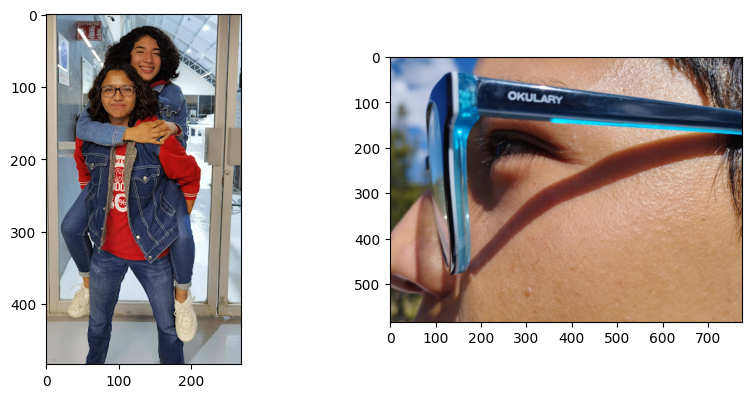

In [1012]:
fig = plt.figure(figsize=(10,10))

tattoo = cv2.imread("../../data/Us.jpg")
o = fig.add_subplot(2,2,1)
tattoo = tattoo[100:, :]
o.imshow(cv2.cvtColor(tattoo, cv2.COLOR_BGR2RGB))

skin = cv2.imread("../../data/Me.jpg")
a = fig.add_subplot(2,2,2)
a.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
tattoo.shape

## Preview

(484, 269, 3)


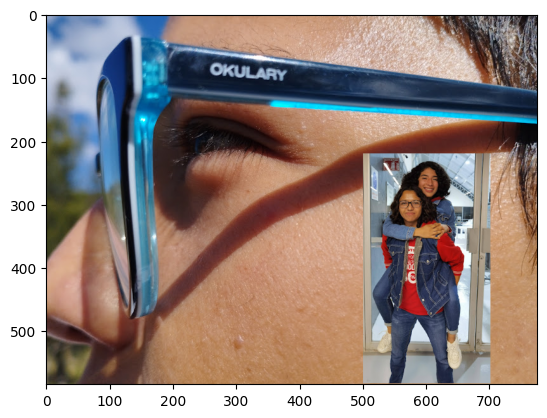

In [1013]:
print(tattoo.shape)
s = 0.75
dim = np.array([tattoo.shape[1]*s, tattoo.shape[0]*s])
dim = dim.astype(int)

skinT = np.copy(skin)
p = cv2.resize(tattoo, dim)
x, y = 500, 220
skinT[y :p.shape[0] + y, x :p.shape[1] + x] = p
plt.imshow(cv2.cvtColor(skinT, cv2.COLOR_BGR2RGB))


## Design tattoo

(484, 269)

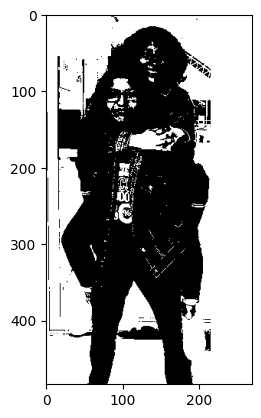

In [1014]:
x = 130
mask = cv2.cvtColor(tattoo, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(mask, x, x, cv2.THRESH_BINARY)
mask = mask/x
mask[:, 215:] = 1
mask[:55, :85] = 1

"""
k = np.ones((6, 7))
k = np.ones((3, 3))
mask = cv2.dilate(mask, k, iterations=2)
k = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 0, 0]
])

#mask = cv2.erode(mask, k, iterations=1)
"""

plt.imshow(mask, cmap = "gray")
mask.shape

(484, 269, 3)


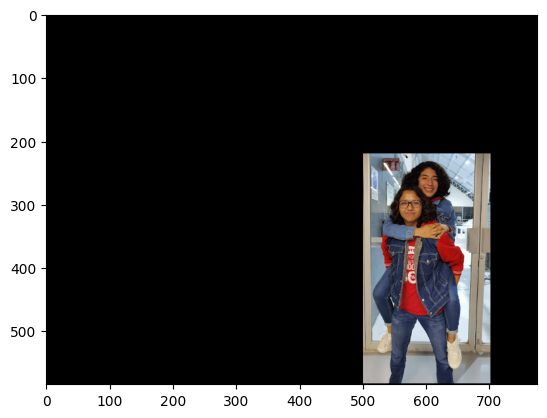

In [1015]:
print(tattoo.shape)
s = 0.75
dim = np.array([tattoo.shape[1]*s, tattoo.shape[0]*s])
dim = dim.astype(int)

tattoo = cv2.resize(tattoo, dim)
x, y = 500, 220
back = np.zeros_like(skin)
back[y :tattoo.shape[0] + y, x :tattoo.shape[1] + x] = tattoo
tattoo = np.copy(back)

plt.imshow(cv2.cvtColor(back, cv2.COLOR_BGR2RGB))


(484, 269)


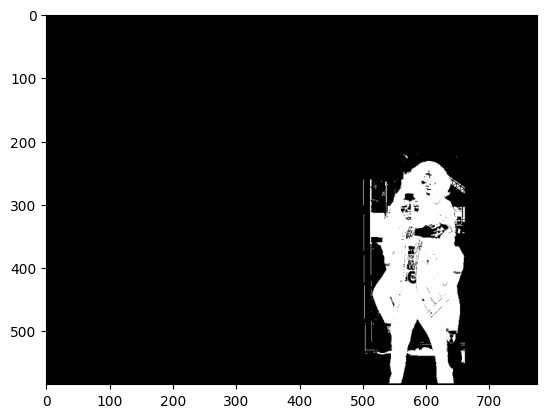

In [1016]:
print(mask.shape)
mask = cv2.resize(mask, dim)
back = np.zeros((skin.shape[0], skin.shape[1]))
back[y :mask.shape[0] + y, x :mask.shape[1] + x] = 1 - mask
mask = np.copy(back)
plt.imshow(mask, cmap = "gray")

In [1017]:
nLevels = 5

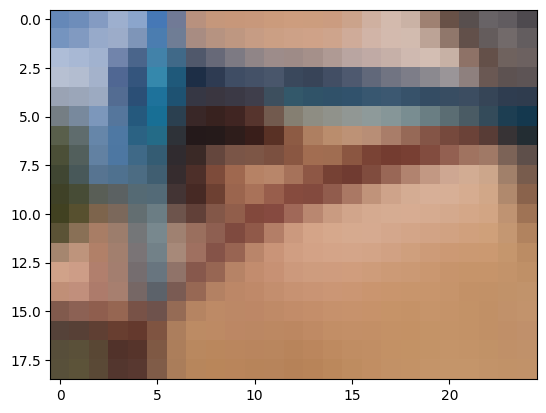

In [1018]:
# generate Gaussian pyramid for A
s = np.copy(skin)
gpSkin = [s]
for i in range(nLevels):
    s = cv2.pyrDown(s)
    gpSkin.append(s)
plt.imshow(cv2.cvtColor(gpSkin[-1], cv2.COLOR_BGR2RGB))

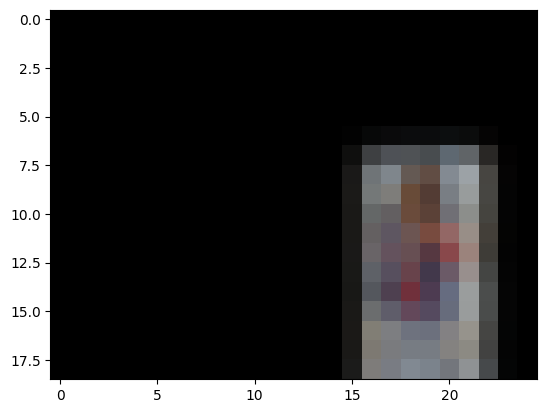

In [1019]:
# generate Gaussian pyramid for A
t = np.copy(tattoo)
gpTattoo = [t]
for i in range(nLevels):
    t = cv2.pyrDown(t)
    gpTattoo.append(t)
plt.imshow(cv2.cvtColor(gpTattoo[-1], cv2.COLOR_BGR2RGB))

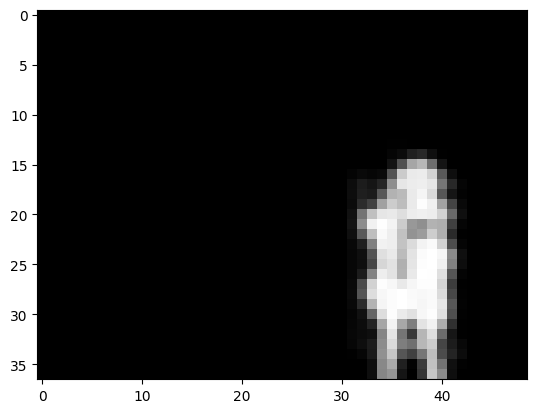

In [1020]:
m = np.copy(mask)
gpMask = [m]
for i in range(nLevels - 1):
    m = cv2.pyrDown(m)
    gpMask.append(m)
plt.imshow(gpMask[-1], cmap = 'gray')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 106 109 111
 113 139 140]


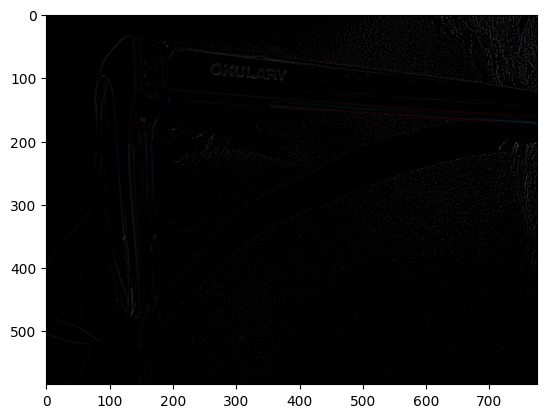

In [1021]:
lpSkin = [gpSkin[nLevels - 1]]
for i in range(nLevels - 1, 0, -1):
    bS = cv2.pyrUp(gpSkin[i], dstsize = (gpSkin[i-1].shape[1], gpSkin[i-1].shape[0]))
    l = cv2.subtract(gpSkin[i-1], bS)
    lpSkin.append(l)
a = 4
plt.imshow(cv2.cvtColor(lpSkin[a], cv2.COLOR_BGR2RGB))
print(np.unique(lpSkin[a]))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 125 138 144]


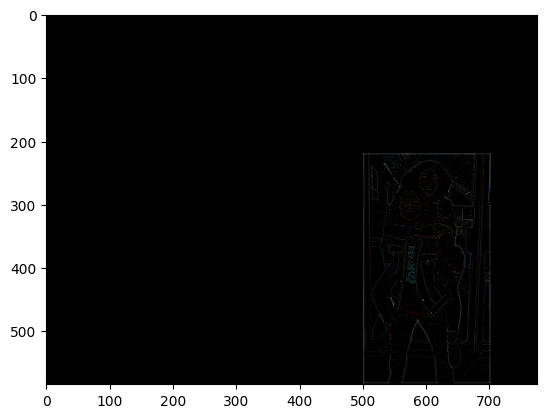

In [1022]:
lpTattoo = [gpTattoo[nLevels - 1]]
for i in range(nLevels - 1, 0, -1):
    bT = cv2.pyrUp(gpTattoo[i], dstsize = (gpTattoo[i-1].shape[1], gpTattoo[i-1].shape[0]))
    l = cv2.subtract(gpTattoo[i-1], bT)
    lpTattoo.append(l)
a = 4
plt.imshow(cv2.cvtColor(lpTattoo[a], cv2.COLOR_BGR2RGB))
print(np.unique(lpTattoo[a]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


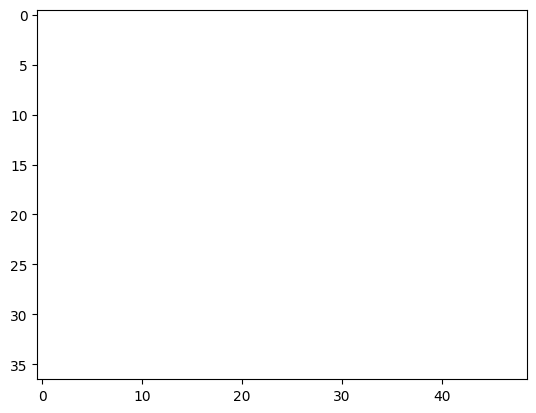

In [1023]:
lFinal = []
for gM, l in zip(gpMask[::-1], zip(lpSkin, lpTattoo)):
    lS, lT = l
    gM = np.stack([gM, gM, gM], -1)
    lF = np.add(np.multiply(lS, (1 - gM)), np.multiply(lT, gM))
    lFinal.append(lF)
plt.imshow(lFinal[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  9.375     9.5       9.8125  ... 223.75    224.0625  224.09375]
[  9.375    9.5      9.8125 ... 230.5625 230.875  241.    ]
[ 10.03320312  10.30175781  10.359375   ... 229.984375   231.62695312
 231.68798828]
[ 10.03320312  10.30175781  10.68603516 ... 248.62695312 250.64257812
 251.68798828]
[ 10.61090088  10.71541595  10.76971436 ... 249.37457275 249.40148926
 249.46539307]
[ 10.61090088  10.71541595  10.76971436 ... 256.09533691 256.14361572
 256.50363159]
[ 10.73551369  10.768857    10.77510786 ... 255.5191803  255.53624725
 255.66268158]
[ 10.73551369  10.768857    10.80902433 ... 279.95564187 280.79913712
 282.15949821]


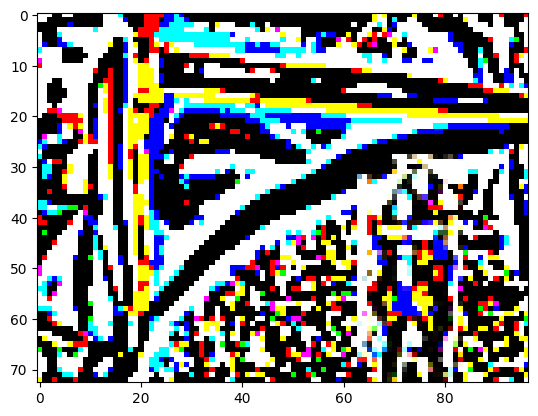

In [1024]:
r = lFinal[0]
for i in range(1, nLevels):
    r = cv2.pyrUp(r, dstsize=(lpSkin[i].shape[1], lpSkin[i].shape[0]))
    if i == 1:
        plt.imshow(lFinal[i])
    print(np.unique(r))
    r = np.add(lFinal[i], r) 
    print(np.unique(r))

(584, 776, 3)
[ 10.73551369  10.768857    10.80902433 ... 279.95564187 280.79913712
 282.15949821]
[0.03804768 0.03816585 0.03830821 ... 0.99218935 0.99517876 1.        ]


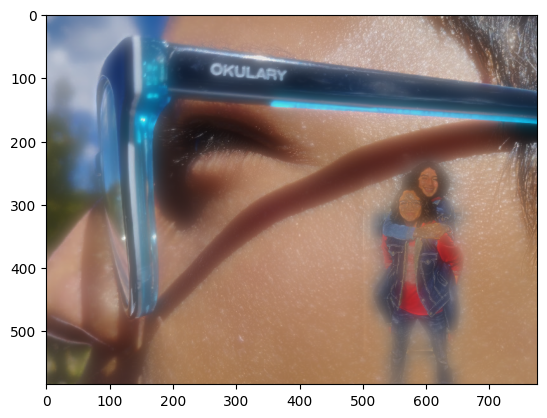

In [1025]:
#plt.imshow(cv2.cvtColor(r.astype(int), cv2.COLOR_BGR2RGB))
print(r.shape)
print(np.unique(r))
r = r / np.max(r)
r = r.astype('float32')
r = cv2.cvtColor(r, cv2.COLOR_BGR2RGB)
#plt.imshow(cv2.cvtColor(r.astype(int), cv2.COLOR_BGR2RGB))
plt.imshow(r)
print(np.unique(r))